# Import Packages

In [1]:
import sys
import os
import shutil
import librosa
import glob
import tqdm
import json
import ast
import random

from librosa import display as ld

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import backend as K

!pip install git+https://github.com/AI-Guru/ngdlm.git
tf.compat.v1.disable_eager_execution()

from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load, dump
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display as ipd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from configparser import ConfigParser

  Cloning https://github.com/AI-Guru/ngdlm.git to /tmp/pip-req-build-dbr9c72_
  Running command git clone -q https://github.com/AI-Guru/ngdlm.git /tmp/pip-req-build-dbr9c72_
  Created wheel for ngdlm: filename=ngdlm-0.0.3-py2.py3-none-any.whl size=32027 sha256=a406a2bc8977e532f562ca5eeac7d7e87d714af3cac9a9f6048d730d1caf4073
  Stored in directory: /tmp/pip-ephem-wheel-cache-cpco8yqg/wheels/93/06/27/e156acb49f475c364c3c9fa4ad4ab7bfa38808bff5bf9c4647
Successfully built ngdlm


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Mount Google Drive
#### 1. First mount

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/sound-of-failure

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/sound-of-failure


#### 2. Remount

In [3]:
%cd ../../..
drive.flush_and_unmount()
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/sound-of-failure

/
Mounted at /gdrive
/gdrive/My Drive/sound-of-failure


# Import Own Modules

In [4]:
sys.path += ['src/01_data_processing', 'src/02_modelling', 'src/03_modell_evaluation',]

import spectrogram as spec
import train_test_split as splt
import train_model_autoencoder as train
import eval_model_autoencoder as eval

hello world
/gdrive/My Drive/sound-of-failure


# Global constants

### First run the scripts for building the config files.

Some of the parameters can be passed through the command line.
At present the command line parameters are the following :

1. conf_base.py : Script for building the base config file (saves in sound-of-failure/conf/conf_base.ini)
        -raw : Pass the location of the raw data dir


2. conf_convAE.py : Script for building the config file holding the parameters for Mel Spectrogram and Convolutional Autoencoder (saves in sound-of-failure/conf/make_conf_convAE.ini). Convolutional Autoencoders can be either Autoencoders or Variational Autoencoders.
        -ae : AE or VAE
        -mel : No. of mels
        -fft : No. of FFT bands
        -hop : Hop length for the sliding window while calculating FFT
        -dim : Time dimension of one spectrogram block after chunking the whole spectrogram
        -s : Step for the sliding window for creating chunks from one spectrogram


To check the description of the command line parameters one could activate the '-h' flag. For example :

In [5]:
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_convAE.py -h

usage: make_conf_convAE.py [-h] [-ae] [-mel] [-fft] [-hop] [-dim] [-s]

Params for Spectrogram and Autoencoder (AE or VAE)

optional arguments:
  -h, --help            show this help message and exit
  -ae , --ae            Type of Autoencoder (AE or VAE)
  -mel , --n_mels       No. of mel bands
  -fft , --n_fft        No. of FFT bands
  -hop , --hop_length   Hop length for FFT calc
  -dim , --dim          Time dimension of Spectrogram block
  -s , --step           Sliding window step for Spectrogram chunking


#### Note the change here : While running VAE we have to specify -ae to VAE in the command line. This ensures that the right config file is created (conf/conf_VAE.ini).

In [6]:
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_base.py -raw '/gdrive/MyDrive/Hitachi_data/dataset'
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_convAE.py -ae VAE -mel 32 -fft 1024 -hop 256 -dim 64 -s 8

### Then read from the config files

There are two config files : 

1. sound-of-failure/conf/**conf_base**.ini
2. sound-of-failure/conf/**conf_VAE**.ini

##### Note the change here : In normal Autoencoders the created config file is called conf_convAE.ini. Now is is called conf_VAE.ini.

In [7]:
base_conf = train.read_config('/gdrive/MyDrive/sound-of-failure/conf/conf_base.ini')
param_conf = train.read_config('/gdrive/MyDrive/sound-of-failure/conf/conf_VAE.ini')

#### Read the parameters directly from the config files

Question : Should the reading of config files be done within notebooks or the source script should directly read from them?

In [8]:
# Directories
RAW_DATA_DIR = base_conf['directories']['raw_data_dir']
BASE_DIR = base_conf['directories']['base_dir']


# Mel spectrograms
N_MELS = param_conf.getint('melspec', 'n_mels')
N_FFT = param_conf.getint('melspec', 'n_fft')
HOP_LENGTH = param_conf.getint('melspec', 'hop_length')
POWER = param_conf.getfloat('melspec', 'power')
WINDOW = param_conf.get('melspec', 'window')


# Subsampling
DIM = param_conf.getint('melspec', 'dim')
STEP = param_conf.getint('melspec', 'step')


# Scaler and cost function
SCALER_TYPE = param_conf.get('model', 'scaler')
LOSS = param_conf.get('model', 'loss')


# Optimizer
OPTIMIZER = param_conf.get('model', 'optimizer')
EPOCHS = param_conf.getint('model', 'epochs')
BATCH_SIZE = param_conf.getint('model', 'batch_size')
VALIDATION_SPLIT = param_conf.getfloat('model', 'val_split')
SHUFFLE = param_conf.getboolean('model', 'shuffle')


# Autoencoder
INPUT_SHAPE = (param_conf.getint('melspec', 'dim'),
               param_conf.getint('melspec', 'n_mels'),
               1)

LATENT_DIM = param_conf.getint('autoencoder', 'latentdim')
NUM_NODES = json.loads(param_conf.get('autoencoder', 'num_nodes'))
NUM_KERNEL = json.loads(param_conf.get('autoencoder', 'num_kernel'))
NUM_STRIDES = param_conf.get('autoencoder', 'num_strides')
NUM_STRIDES = list(ast.literal_eval(NUM_STRIDES))


# Data
DB = param_conf.get('data', 'noise')
MACHINE_TYPE = param_conf.get('data', 'machine')
MACHINE_ID = param_conf.get('data', 'machine_id')

# Execute preprocessing steps
#### 1. Generate unscaled mel spectrograms (~ 5 minutes)

In [9]:
spec.make_mel_dirs(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)

spec.make_mels(RAW_DATA_DIR, BASE_DIR, 
               DB, MACHINE_TYPE, MACHINE_ID, 
               N_MELS, N_FFT, HOP_LENGTH, POWER, WINDOW)

Generate normal spectrograms and save to /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/normal.
Generate abnormal spectrograms and save to /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/abnormal.


#### 2. Separate train and test files

In [10]:
train_files, train_labels, test_files, test_labels = splt.make_train_test_split(BASE_DIR, 
                                                                           DB, MACHINE_TYPE, MACHINE_ID, 
                                                                           random_seed=1)

#### 3. Fit scaler to train files

#### 3.1 Plot an example spectrogram

Just a sanity check

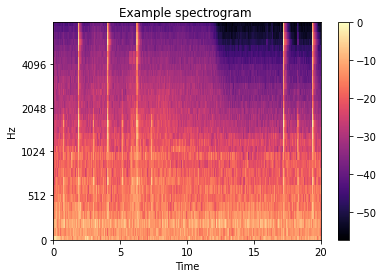

In [11]:
spect = np.load('/gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/normal/00000990.npy')

fig, ax = plt.subplots()
plt.title("Example spectrogram ")
img = ld.specshow(spect, 
                    x_axis='time', 
                    y_axis='mel', 
                    sr=16000, 
                    fmax=8000, 
                    ax=ax)

fig.colorbar(img, ax=ax)
plt.show()
plt.close()

In [12]:
scaler = spec.create_scaler(SCALER_TYPE)
spec.fit_scaler_to_mel_files(scaler, train_files)

#### 4. Generate training data from scaling and subsampling mel spectrograms

In [13]:
train_data = splt.generate_train_data(train_files, scaler, DIM, STEP)

In [14]:
train_data.shape

(62784, 64, 32, 1)

# Modelling

### Build Variational Autoencoder

While training a new model the model should be called fresh from `train/load_new_model`. 

For prediction or model evaluation, one should call `train/load_saved_model`



In [15]:
my_model = train.load_new_model(model_name='VAE',
                                input_shape=INPUT_SHAPE,
                                num_nodes=NUM_NODES,
                                num_kernel=NUM_KERNEL,
                                num_strides=NUM_STRIDES,
                                latent_dim=LATENT_DIM)

print(my_model.summary())

Encoder:
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv_enc0 (Conv2D)              (None, 64, 16, 32)   832         encoder_input[0][0]              
__________________________________________________________________________________________________
batchnorm_enc0 (BatchNormalizat (None, 64, 16, 32)   128         conv_enc0[0][0]                  
__________________________________________________________________________________________________
relu_enc0 (ReLU)                (None, 64, 16, 32)   0           batchnorm_enc0[0][0]             
___________________________________________________________________________________

#### NOTE THE CHANGE : 
    1. `train.compile_model`: Now the model is compiled with a learning rate that can be specified by the user. Currently three optimizers can be chosen:
      -Adam
      -RMSprop
      -SGD

    2. train.train_model: In the model training there are two options:
      A. Train with callbacks: If callback=True, then EarlyStopping and ModelCheckpoint is enabled. In that case a patience and a path to save the best model must be specified.
      B. Train without callbacks: Set callback=False in that case. No EarlyStopping and also the best model will not be saved.





Train on 56505 samples, validate on 6279 samples
Epoch 1/100
56505/56505 [==============================] - ETA: 0s - loss: 0.1057

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.06478, saving model to /gdrive/MyDrive/sound-of-failure/models/00_trial_VAE.hdf5
56505/56505 [==============================] - 29s 512us/sample - loss: 0.1057 - val_loss: 0.0648
Epoch 2/100
56505/56505 [==============================] - ETA: 0s - loss: 0.0563
Epoch 00002: val_loss improved from 0.06478 to 0.05558, saving model to /gdrive/MyDrive/sound-of-failure/models/00_trial_VAE.hdf5
56505/56505 [==============================] - 25s 448us/sample - loss: 0.0563 - val_loss: 0.0556
Epoch 3/100
56505/56505 [==============================] - ETA: 0s - loss: 0.0526
Epoch 00003: val_loss improved from 0.05558 to 0.05066, saving model to /gdrive/MyDrive/sound-of-failure/models/00_trial_VAE.hdf5
56505/56505 [==============================] - 26s 459us/sample - loss: 0.0526 - val_loss: 0.0507
Epoch 4/100
56505/56505 [==============================] - ETA: 0s - loss: 0.0505
Epoch 00004: val_loss did not improve from 0.05066
56505/56505 [=========

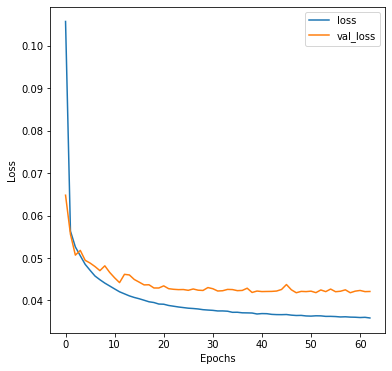

In [16]:
# Compile model
train.compile_model(model=my_model, 
              optimizer=OPTIMIZER, 
              loss=LOSS, 
              learning_rate=0.001)

# Train model
history = train.train_model(model=my_model,
          train_data=train_data,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_split=VALIDATION_SPLIT,
          shuffle=SHUFFLE,
          callback=True,
          patience=15,
          model_outdir='/gdrive/MyDrive/sound-of-failure/models/00_trial_VAE.hdf5')

# Plot model history
train.plot_train_history(history)

# Model evaluation


In [17]:
"""saved_model = train.load_saved_model('/gdrive/MyDrive/sound-of-failure/models/00_trial_VAE.hdf5')

y_pred = np.zeros(len(test_files))
y_true = test_labels

for idx, test_file in tqdm.tqdm(enumerate(test_files), total=len(test_files)):
  #print("File no.={}, location={}, label={}".format(idx, test_file, test_label))

  mel = np.load(test_file)

  scaled_mel = spec.apply_scaler_to_mel(scaler, mel)

  batch = splt.subsample_from_mel(scaled_mel, DIM, STEP)

  batch_prediction = saved_model.predict(batch)

  squared_error = np.square(batch - batch_prediction)
  channelwise_error = np.mean(squared_error, axis=-1)
  reconstruction_error = np.mean(channelwise_error)

  y_pred[idx] = reconstruction_error


auc_score = metrics.roc_auc_score(y_true, y_pred)
print("Roc AUC score={}".format(auc_score))"""

'saved_model = train.load_saved_model(\'/gdrive/MyDrive/sound-of-failure/models/00_trial_VAE.hdf5\')\n\ny_pred = np.zeros(len(test_files))\ny_true = test_labels\n\nfor idx, test_file in tqdm.tqdm(enumerate(test_files), total=len(test_files)):\n  #print("File no.={}, location={}, label={}".format(idx, test_file, test_label))\n\n  mel = np.load(test_file)\n\n  scaled_mel = spec.apply_scaler_to_mel(scaler, mel)\n\n  batch = splt.subsample_from_mel(scaled_mel, DIM, STEP)\n\n  batch_prediction = saved_model.predict(batch)\n\n  squared_error = np.square(batch - batch_prediction)\n  channelwise_error = np.mean(squared_error, axis=-1)\n  reconstruction_error = np.mean(channelwise_error)\n\n  y_pred[idx] = reconstruction_error\n\n\nauc_score = metrics.roc_auc_score(y_true, y_pred)\nprint("Roc AUC score={}".format(auc_score))'

### Load trained model

In [18]:
saved_model = train.load_saved_model('/gdrive/MyDrive/sound-of-failure/models/00_trial_VAE.hdf5')

### Reconstruction error and ROC curve

In [19]:
# Reconstruction loss for test and train spectrograms
reco_loss_test = eval.reco_loss(model=saved_model, 
                                scaler=scaler,
                                dim=DIM,
                                step=STEP,
                                test_files=test_files)

reco_loss_train = eval.reco_loss(model=saved_model, 
                                scaler=scaler,
                                dim=DIM,
                                step=STEP,
                                test_files=train_files)

  0%|          | 0/238 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
100%|██████████| 872/872 [00:12<00:00, 67.20it/s]


Roc AUC score=0.970129228161853


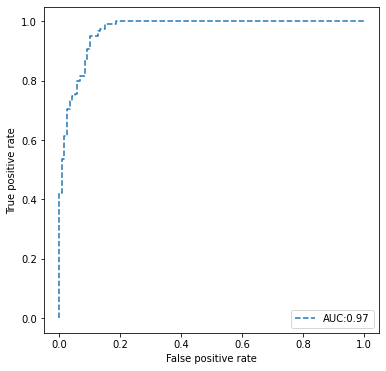

In [20]:
# ROC curve and ROC AUC score (for test data)
eval.plot_roc_curve(test_labels, reco_loss_test)

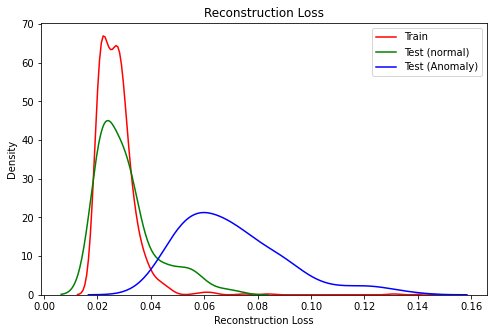

In [21]:
# Visualize separation between normal and abnormal reconstruction loss
eval.plot_losses(y_true=test_labels,
                 y_pred=reco_loss_test,
                 y_train=reco_loss_train,
                 title="Reconstruction Loss",
                 xlabel='Reconstruction Loss')

### KL Divergence loss

In [22]:
# KL-divergence for the test and train spectrograms
kl_loss_test = eval.kl_loss(model=my_model, 
                            scaler=scaler,
                            dim=DIM,
                            step=STEP,
                            test_files=test_files)

kl_loss_train = eval.kl_loss(model=my_model, 
                            scaler=scaler,
                            dim=DIM,
                            step=STEP,
                            test_files=train_files)

  0%|          | 0/238 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
100%|██████████| 872/872 [06:26<00:00,  2.26it/s]


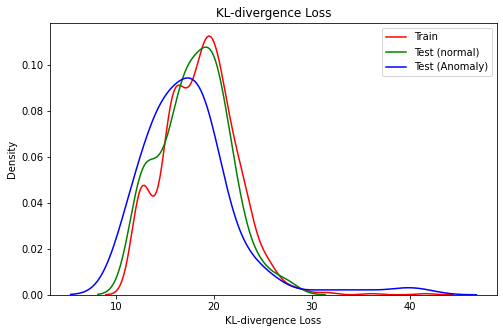

In [23]:
# Visualize separation between normal and abnormal KL_divergence loss
eval.plot_losses(y_true=test_labels,
                 y_pred=kl_loss_test,
                 y_train=kl_loss_train,
                 title="KL-divergence Loss",
                 xlabel='KL-divergence Loss')